In [5]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras_preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

ImportError: cannot import name 'pad_sequences' from 'keras.preprocessing.sequence' (/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/keras/preprocessing/sequence.py)

In [40]:
# function to read raw text file
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text

In [41]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [42]:
data = read_text("/home/azureuser/cloudfiles/code/Users/NAZAR.KHOKHLA.2023/deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [43]:
deu_eng = deu_eng[:50000,:]

In [44]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

deu_eng

array([['Go', 'Geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi', 'Hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi', 'Grüß Gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['Im giving up smoking', 'Ich höre mit dem Rauchen auf',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #256952 (minshirui) & #407184 (MUIRIEL)'],
       ['Im glad I was nearby', 'Ich bin froh dass ich in der Nähe war',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2547219 (CK) & #3448316 (Pfirsichbaeumchen)'],
       ['Im glad Tom has gone', 'Ich bin froh dass Tom weg ist',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2547217 (CK) & #5299642 (Pfirsichbaeumchen)']],
      dtype='<U537')

In [45]:
# convert text to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

deu_eng

array([['go', 'geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['hi', 'hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['hi', 'grüß gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['im giving up smoking', 'ich höre mit dem rauchen auf',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #256952 (minshirui) & #407184 (MUIRIEL)'],
       ['im glad i was nearby', 'ich bin froh dass ich in der nähe war',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2547219 (CK) & #3448316 (Pfirsichbaeumchen)'],
       ['im glad tom has gone', 'ich bin froh dass tom weg ist',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2547217 (CK) & #5299642 (Pfirsichbaeumchen)']],
      dtype='<U537')

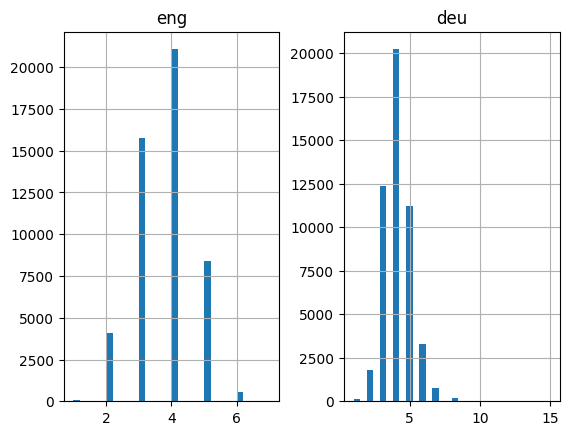

In [46]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
      deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

length_df.hist(bins = 30)
plt.show()

In [47]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [48]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6256


In [49]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10329


In [50]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [51]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [52]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [53]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [54]:
# model compilation
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)

In [55]:
rms = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [56]:
cap=None

In [57]:
filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [58]:
%%capture cap
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)



INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets
INFO:tensorflow:Assets w

AttributeError: 'NoneType' object has no attribute 'stdout'

In [2]:
#

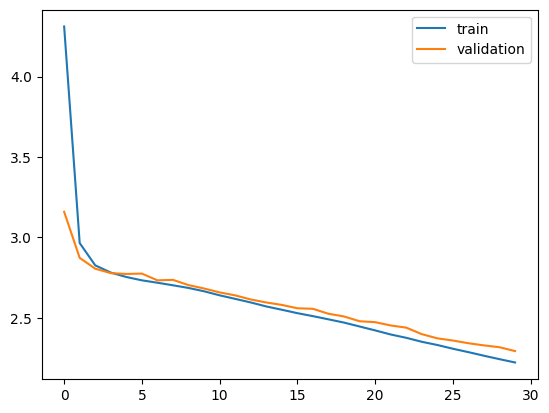

In [65]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [66]:
model = load_model('model.h1.24_jan_19')
preds = argmax(model.predict(testX.reshape((testX.shape[0],testX.shape[1]))), axis=-1)

2024-04-16 10:41:59.790835: W tensorflow/core/common_runtime/graph_constructor.cc:834] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2024-04-16 10:42:00.466612: W tensorflow/core/common_runtime/graph_constructor.cc:834] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2024-04-16 10:42:00.477702: W tensorflow/core/common_runtime/graph_constructor.cc:834] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2024-04-16 10:42:00.816473: W tensorflow/core/common_runtime/graph_constructor.cc:834] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2024-04-16 10:42:00.828548: W tensorflow/core/common_runtime/graph_constructor.cc:834] Node 'cond' has 5 outputs but the _output_sh

313/313 [==============================] - 14s 39ms/step


In [67]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [68]:
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t) 

    preds_text.append(' '.join(temp))

In [69]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [70]:
# print 15 rows randomly
pred_df.head(15)

,actual,predicted
0,i know that already,i you that
1,whos she,this is
2,do you have it,do you
3,use your feet,dont you me
4,that was the trouble,the is
5,he took off his coat,he has a
6,tom went sightseeing,tom is a
7,i tried on the shoes,i have a
8,open those doors,the is
9,ive got to help tom,i know tom


In [71]:
# import required libraries
from azure.ai.ml import MLClient
from azure.ai.ml.entities import (
    ManagedOnlineEndpoint,
    ManagedOnlineDeployment,
    Model,
    Environment,
    CodeConfiguration,
)
from azure.identity import DefaultAzureCredential

In [72]:
# enter details of your Azure Machine Learning workspace
subscription_id = "0131ba9c-52ec-4a68-9ca0-643b19efa512"
resource_group = "NAZAR.KHOKHLA.2023-rg"
workspace = "llm-builing"  

In [73]:
# get a handle to the workspace
ml_client = MLClient(
    DefaultAzureCredential(), subscription_id, resource_group, workspace
)

In [74]:
# Define an endpoint name
endpoint_name = "my-endpoint"

# Example way to define a random name
import datetime

endpoint_name = "endpt-" + datetime.datetime.now().strftime("%m%d%H%M%f")

# create an online endpoint
endpoint = ManagedOnlineEndpoint(
    name = endpoint_name, 
    description="this is a sample endpoint",
    auth_mode="key"
)

In [75]:
model = Model(path="../model-1/model/sklearn_regression_model.pkl")
env = Environment(
    conda_file="../model-1/environment/conda.yaml",
    image="mcr.microsoft.com/azureml/openmpi4.1.0-ubuntu20.04:latest",
)

blue_deployment = ManagedOnlineDeployment(
    name="blue",
    endpoint_name=endpoint_name,
    model=model,
    environment=env,
    code_configuration=CodeConfiguration(
        code="../model-1/onlinescoring", scoring_script="score.py"
    ),
    instance_type="Standard_DS3_v2",
    instance_count=1,
)

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/batch/tasks/shared/LS_root/mounts/clusters/llm-demo/code/Users/model-1/model/sklearn_regression_model.pkl'